<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment4/Assignment_4_DenseNet_IDL_Meghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team Assignment


1.   Srinath Mannam (229750)
2.   Meghana Rao (234907)
3.   Govind Shukla (235192)

###Import statements

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

###Densenet model configuration

In [ ]:
class Cifar10_Densenet:

  def __init__(self, **kwargs):
     super().__init__(**kwargs)
     self.cifar10 = tf.keras.datasets.cifar10
     (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.cifar10.load_data()
     self.num_classes = 10
     print(self.train_labels[0])
     plt.imshow(self.train_images[0])
  
  def set_train_test_data(self):
    train_data = tf.data.Dataset.from_tensor_slices((self.train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, self.train_labels.astype(np.int32)))
    train_data = train_data.shuffle(buffer_size=60000).batch(128).repeat()
    test_data = tf.data.Dataset.from_tensor_slices((self.test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, self.test_labels.astype(np.int32))).batch(128)
    
    return train_data, test_data

  #----desenet paper architecture-----------
  def set_densenet_model(self, k, num_of_dense_block_layers):
    
    input = tf.keras.layers.Input((32, 32, 3))

    conv_layer_1 = tf.keras.layers.Conv2D(k*2, (7,7), padding="same", name="conv_layer_1")(input)
    pool_1 = tf.keras.layers.MaxPool2D(strides=(2,2), padding= 'same')(conv_layer_1)
    dense_block_1 = self.set_dense_block(pool_1, num_of_dense_block_layers, k)
    transition_block_1 = self.set_transition_block(dense_block_1, k)
    dense_block_2 = self.set_dense_block(transition_block_1, num_of_dense_block_layers, k)
    transition_block_2 = self.set_transition_block(dense_block_2, k)
    dense_block_3 = self.set_dense_block(transition_block_2, num_of_dense_block_layers, k)
    transition_block_3 = self.set_transition_block(dense_block_3, k)
    dense_block_4 = self.set_dense_block(transition_block_3, num_of_dense_block_layers, k)
    dense_block_4 = tf.keras.layers.BatchNormalization()(dense_block_4)
    dense_block_4 = tf.keras.layers.ReLU()(dense_block_4)
    pool_2 = tf.keras.layers.GlobalAvgPool2D()(dense_block_4)
    flatten = tf.keras.layers.Flatten()(pool_2)
    dense_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(flatten)

    output = dense_layer
    
    model = tf.keras.Model(inputs=input, outputs=output, name="DENSENET_MODEL_1")
    optimizer = tf.optimizers.Adam() 
    loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    return model, optimizer, loss_fn, acc_metric


  def set_densenet_model_2(self, k, num_of_dense_block_layers):
    
    input = tf.keras.layers.Input((32, 32, 3))

    conv_layer_1 = tf.keras.layers.Conv2D(k*2, (2,2), strides=(1,1), padding="same", name="conv_layer_1")(input)
    dense_block_1 = self.set_dense_block(conv_layer_1, num_of_dense_block_layers, k)
    transition_block_1 = self.set_transition_block(dense_block_1, k)
    dense_block_2 = self.set_dense_block(transition_block_1, num_of_dense_block_layers, k)
    transition_block_2 = self.set_transition_block(dense_block_2, k)
    dense_block_3 = self.set_dense_block(transition_block_2, num_of_dense_block_layers, k)
    pool_1 = tf.keras.layers.GlobalAvgPool2D()(dense_block_3)
    dense_layer = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(pool_1)

    output = dense_layer
    
    model = tf.keras.Model(inputs=input, outputs=output, name="DENSENET_MODEL_2")
    optimizer = tf.optimizers.Adam() 
    loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    return model, optimizer, loss_fn, acc_metric
 
  
  def set_dense_block(self, prev_layer, num_of_dense_block_layers, k):
    dense_block_num = 0
    dense_block_output_layer = prev_layer
    for dense_block_num in range(num_of_dense_block_layers):
      dense_block_layer = tf.keras.layers.BatchNormalization()(dense_block_output_layer)
      dense_block_layer = tf.keras.layers.ReLU()(dense_block_layer)
      dense_block_layer = tf.keras.layers.Conv2D(k * 4, (1,1), padding="same")(dense_block_layer)
      dense_block_layer = tf.keras.layers.Dropout(0.2)(dense_block_layer)
      dense_block_layer = tf.keras.layers.BatchNormalization()(dense_block_layer)
      dense_block_layer = tf.keras.layers.ReLU()(dense_block_layer)
      dense_block_layer = tf.keras.layers.Conv2D(k * 1, (3,3), padding="same")(dense_block_layer)
      dense_block_layer = tf.keras.layers.Dropout(0.2)(dense_block_layer)

      dense_block_output_layer = tf.keras.layers.concatenate([dense_block_output_layer, dense_block_layer])
    
    return dense_block_output_layer

  def set_transition_block(self, prev_dense_block, k):
    transition_block_layer = tf.keras.layers.BatchNormalization()(prev_dense_block)
    transition_block_layer = tf.keras.layers.ReLU()(transition_block_layer)
    transition_block_layer = tf.keras.layers.Conv2D(k * 4, (1,1) padding="same")(transition_block_layer)
    transition_block_layer = tf.keras.layers.Dropout(0.2)(transition_block_layer)
    transition_block_pool_layer = tf.keras.layers.AveragePooling2D(strides=(2,2), padding= 'same')(transition_block_layer)

    return transition_block_pool_layer


### Function: To compile, fit and evaluate the model

In [ ]:
def model_compile_fit_evaluate(train_data, test_data, model, steps_per_epoch, epochs, model_optimizer, model_loss_fn, model_acc_metric, run_eagerly_value):
  model.summary()

  #---model compile-----
  model.compile(
      loss = model_loss_fn,
      optimizer = model_optimizer,
      metrics = model_acc_metric,
      run_eagerly = run_eagerly_value # eager execution
      )
  
  #---model fit------
  train_scores = model.fit(train_data, epochs=epochs)

  #---model evaluate----
  test_scores = model.evaluate(test_data)
  print("Test loss:", test_scores[0])
  print("Test accuracy:", test_scores[1])


###CIFAR10 Dataset

[6]


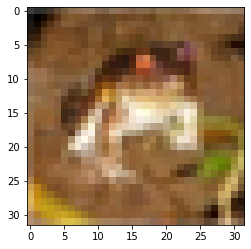

In [ ]:
  # --------CIFAR10------------
  cifar_10 = Cifar10_Densenet()
  cifar_10_train_data, cifar_10_test_data = cifar_10.set_train_test_data()

####Model 1
###### For steps_per_epoch = 2000, epochs = 20, k = 32, dense_block_layers = 6

In [ ]:
  #--------------model 1-------------------------- 
  print("--------For steps_per_epoch = 2000, epochs = 20, k = 32, dense_block_layers = 6---------")
  cifar_10_model_1, cifar_10_model_1_optimizer, cifar_10_model_1_loss_fn, cifar_10_model_1_acc_metric = cifar_10.set_densenet_model(32, 6)
  print("-------Cifar10 model_1 Summary----------")
  model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_1, 
                             2000, 20, cifar_10_model_1_optimizer, cifar_10_model_1_loss_fn, cifar_10_model_1_acc_metric, False)

--------For steps_per_epoch = 2000, epochs = 20, k = 32, dense_block_layers = 6---------
-------Cifar10 model_1 Summary----------
Model: "DENSENET_MODEL_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv_layer_1[0][0]']           
 alization)                                                                                       
                                                    

####Model 2
###### For steps_per_epoch = 2000, epochs = 10, k = 36, dense_block_layers = 18

In [ ]:
  #--------------model 2--------------------------
  print("--------For steps_per_epoch = 2000, epochs = 10, k = 36, dense_block_layers = 18---------")
  cifar_10_model_2, cifar_10_model_2_optimizer, cifar_10_model_2_loss_fn, cifar_10_model_2_acc_metric = cifar_10.set_densenet_model(36, 18)
  print("-------Cifar10 model_2 Summary----------")
  model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_2, 
                             2000, 10, cifar_10_model_2_optimizer, cifar_10_model_2_loss_fn, cifar_10_model_2_acc_metric,False)

--------For steps_per_epoch = 2000, epochs = 10, k = 36, dense_block_layers = 18---------
-------Cifar10 model_2 Summary----------
Model: "DENSENET_MODEL_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 16, 16, 72)   10656       ['input_2[0][0]']                
                                                                                                  
 batch_normalization_148 (Batch  (None, 16, 16, 72)  288         ['conv_layer_1[0][0]']           
 Normalization)                                                                                   
                                                   

####Model 3
###### For epochs = 2, k = 32, dense_block_layers = 10, repeat(30)

In [ ]:
  #--------------model 3--------------------------
  print("--------For epochs = 2, k = 32, dense_block_layers = 10, repeat(30)---------")
  cifar_10_model_3, cifar_10_model_3_optimizer, cifar_10_model_3_loss_fn, cifar_10_model_3_acc_metric = cifar_10.set_densenet_model(32, 10)
  print("-------Cifar10 model_3 Summary----------")
  model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_3, 
                             None, 2, cifar_10_model_3_optimizer, cifar_10_model_3_loss_fn, cifar_10_model_3_acc_metric, False)

--------For steps_per_epoch = 5000, epochs = 5, k = 32, dense_block_layers = 10---------
-------Cifar10 model_3 Summary----------
Model: "DENSENET_MODEL_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_380 (Batch  (None, 16, 16, 64)  256         ['conv_layer_1[0][0]']           
 Normalization)                                                                                   
                                                    

####Model 4
###### For steps_per_epoch = 2000, epochs = 30, k = 36, dense_block_layers = 18

In [ ]:
  #--------------model 4--------------------------
  print("--------For epochs = 20, k = 36, dense_block_layers = 18---------")
  cifar_10_model_4, cifar_10_model_4_optimizer, cifar_10_model_4_loss_fn, cifar_10_model_4_acc_metric = cifar_10.set_densenet_model(36, 18)
  print("-------Cifar10 model_4 Summary----------")
  model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_4, 
                             None, 20, cifar_10_model_4_optimizer, cifar_10_model_4_loss_fn, cifar_10_model_4_acc_metric, False)

--------For epochs = 20, k = 36, dense_block_layers = 18, 3 dense block layers---------
-------Cifar10 model_4 Summary----------
Model: "DENSENET_MODEL_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 32, 32, 72)   10656       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 72)  288         ['conv_layer_1[0][0]']           
 alization)                                                                                       
                                                     

####Model 5
###### For epochs = 2, k = 32, dense_block_layers = 6, 3 dense block layers

In [ ]:
  #--------------model 5--------------------------
  print("--------For epochs = 2, k = 32, dense_block_layers = 6, 3 dense block layers---------")
  cifar_10_model_5, cifar_10_model_5_optimizer, cifar_10_model_5_loss_fn, cifar_10_model_5_acc_metric = cifar_10.set_densenet_model_2(32, 6)
  print("-------Cifar10 model_4 Summary----------")
  model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_5, 
                             None, 2, cifar_10_model_5_optimizer, cifar_10_model_5_loss_fn, cifar_10_model_5_acc_metric, False)

--------For epochs = 30, k = 36, dense_block_layers = 18, 3 dense block layers---------
-------Cifar10 model_4 Summary----------
Model: "DENSENET_MODEL_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv_layer_1 (Conv2D)          (None, 32, 32, 64)   832         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_402 (Batch  (None, 32, 32, 64)  256         ['conv_layer_1[0][0]']           
 Normalization)                                                                                   
                                                     

#### Using Main()

In [ ]:
#def main():

  # --------CIFAR10------------
  #cifar_10 = Dataset_Cifar10()
  #cifar_10_train_data, cifar_10_test_data = cifar_10.set_train_test_data()

  #--------------model 1-------------------------- 
  #print("--------For steps_per_epoch = 2000, epochs = 20, k = 32, dense_block_layers = 6---------")
  #cifar_10_model_1, cifar_10_model_1_optimizer, cifar_10_model_1_loss_fn, cifar_10_model_1_acc_metric = cifar_10.set_densenet_model(32, 6)
  #print("-------Cifar10 model_1 Summary----------")
  #model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_1, 2000, 20, False)

  #--------------model 2--------------------------
  #print("--------For steps_per_epoch = 2000, epochs = 10, k = 36, dense_block_layers = 18---------")
  #cifar_10_model_2, cifar_10_model_2_optimizer, cifar_10_model_2_loss_fn, cifar_10_model_2_acc_metric = cifar_10.set_densenet_model(36, 18)
  #print("-------Cifar10 model_2 Summary----------")
  #model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_2, 2000, 10, False)

  #--------------model 3--------------------------
  #print("--------For steps_per_epoch = 5000, epochs = 5, k = 20, dense_block_layers = 10---------")
  #cifar_10_model_3, cifar_10_model_3_optimizer, cifar_10_model_3_loss_fn, cifar_10_model_3_acc_metric = cifar_10.set_densenet_model(20, 10)
  #print("-------Cifar10 model_3 Summary----------")
  #model_compile_fit_evaluate(cifar_10_train_data, cifar_10_test_data, cifar_10_model_3, 5000, 5, True)


In [ ]:
#if __name__ == "__main__":
    #main()